In [1]:
# Implement the fault-tolerant error correction of [[15,7,3]] code using Steane's scheme. For the preparation of logical states, we adopt the simpler two-ancialla scheme in our paper.
#steane 1573
trialsforall=100000
valuesxd=13
low=1
high=25
from utility import *

# Prepare logical |0> and |+> states for syndrome measurement, following the circuit in Appendix C FIG. 9, which uses bare flag ancilla.
def prepLogical0(errors, errorRates, verbose):
  z = 1
  while(z):
    prepX(15, errors, errorRates)
    prepX(16, errors, errorRates)
    prepZ(17, errors, errorRates)
    prepX(18, errors, errorRates)
    prepZ(19, errors, errorRates)
    prepZ(20, errors, errorRates)
    prepZ(21, errors, errorRates)
    prepX(22, errors, errorRates)
    prepZ(23, errors, errorRates)
    prepZ(24, errors, errorRates)
    prepZ(25, errors, errorRates)
    prepZ(26, errors, errorRates)
    prepZ(27, errors, errorRates)
    prepZ(28, errors, errorRates)
    prepZ(29, errors, errorRates)
    prepZ(30, errors, errorRates)
    cnot(22, 30, errors, errorRates)
    cnot(18, 30, errors, errorRates)
    cnot(16, 30, errors, errorRates)
    cnot(15, 30, errors, errorRates)
    for i in range(4):
      for j in range(7):
        cnot(15+cnotWires[i][0], 15+cnotWires[i][j+1], errors, errorRates)
    cnot(15, 30, errors, errorRates)
    cnot(16, 30, errors, errorRates)
    cnot(18, 30, errors, errorRates)
    cnot(22, 30, errors, errorRates)
    z = measZ(30, errors, errorRates)
    if verbose&z:
      print("ancilla zero fail")

def prepLogicalPlus(errors, errorRates, verbose):
  z = 1
  while(z):
    prepZ(15, errors, errorRates)
    prepZ(16, errors, errorRates)
    prepX(17, errors, errorRates)
    prepZ(18, errors, errorRates)
    prepX(19, errors, errorRates)
    prepX(20, errors, errorRates)
    prepX(21, errors, errorRates)
    prepZ(22, errors, errorRates)
    prepX(23, errors, errorRates)
    prepX(24, errors, errorRates)
    prepX(25, errors, errorRates)
    prepX(26, errors, errorRates)
    prepX(27, errors, errorRates)
    prepX(28, errors, errorRates)
    prepX(29, errors, errorRates)
    prepX(30, errors, errorRates)
    cnot(30, 22, errors, errorRates)
    cnot(30, 18, errors, errorRates)
    cnot(30, 16, errors, errorRates)
    cnot(30, 15, errors, errorRates)
    for i in range(4):
      for j in range(7):
        cnot(15+cnotWires[i][j+1], 15+cnotWires[i][0], errors, errorRates)
    cnot(30, 15, errors, errorRates)
    cnot(30, 16, errors, errorRates)
    cnot(30, 18, errors, errorRates)
    cnot(30, 22, errors, errorRates)
    z = measX(30, errors, errorRates)
    if verbose&z:
      print ("ancilla zero fail")

# Perform transversal cnot between data block and logical |0> and |+>. Correct the error through parity checks.
def correctErrors(errors, errorRates, verbose=False):
  if verbose: print ("starting Xsyndrome")
  prepLogical0(errors, errorRates, verbose)
  Xsyndrome = 0
  for i in range(15):
    cnot(15+i, i, errors, errorRates)
    if measX(15+i, errors, errorRates):
      Xsyndrome ^= (1+i)
  if Xsyndrome:
    errors.z ^= 1<<(Xsyndrome-1)
  if verbose: print("starting Zsyndrome")
  prepLogicalPlus(errors, errorRates, verbose)
  Zsyndrome = 0
  for i in range(15):
    cnot(i, 15+i, errors, errorRates)
    if measZ(15+i, errors, errorRates):
      Zsyndrome ^= (1+i)
  if Zsyndrome:
    errors.x ^= 1<<(Zsyndrome-1)


# Find least weight representation modulo stabilizers.
def weight(errors):
  return bin((errors.x | errors.z) & ((1 << 15) - 1)).count("1")

# This is the matrix indexing the non-identity positions of the stabilizers 
cnotWires = [[k for k in range(15) if ((k+1)>>(3-i))&1==1] for i in range(4)]

stabilizers = [[0,0] for i in range(8)]
for i in range(4):
  for j in range(8):
    stabilizers[i][0] += 1<<cnotWires[i][j]
for i in range(4):
  for j in range(8):
    stabilizers[i+4][1] += 1<<cnotWires[i][j]

def reduceError(errors): 
  bestErrors = Errors(errors.x, errors.z)
  bestWeight = weight(bestErrors)
  trialErrors = Errors(0, 0)
  for k in range(1, 1<<(len(stabilizers))):
    trialErrors.x = errors.x
    trialErrors.z = errors.z
    for digit in range(len(stabilizers)):
      if (k>>digit)&1: 
        trialErrors.x ^= stabilizers[digit][0]
        trialErrors.z ^= stabilizers[digit][1]
    if weight(trialErrors) < bestWeight: 
      bestErrors.x = trialErrors.x
      bestErrors.z = trialErrors.z
      bestWeight = weight(bestErrors)
  return bestErrors

# Run consecutive trials of error correction with physical error rate of gamma, and count the number of failures, i.e., when the trialing error is not correctable by perfect error correction.
# The logical error rate is calculated as the ratio of failures over trials. 
def simulateErrorCorrection(gamma, trials): 
  errors = Errors(0, 0)
  errorsCopy = Errors(0, 0)
  
  errorRates0 = ErrorRates(0, 0, 0)
  errorRates = ErrorRates((4/15.)*gamma, gamma, (4/15.)*gamma)
  
  failures = 0
  for k in range(trials): 
    correctErrors(errors, errorRates)
    errorsCopy.x = errors.x
    errorsCopy.z = errors.z
    correctErrors(errorsCopy, errorRates0)
    errorsCopy = reduceError(errorsCopy)
    if (errorsCopy.x & ((1<<15)-1)) or (errorsCopy.z & ((1<<15)-1)): 
      failures += 1
      errors.x = 0
      errors.z = 0
  print(failures)
  return failures/trials


In [2]:
# Wrapper function for the plot. More trials are needed for small gammas due to the confidence interval.
# gammas = [10**(i/10.-4) for i in range(21)]
# logical_failure_rates = []
# for i in range(10):
#   print "gamma=10^(%d/10-4), trials=10^7"% i
#   simulateErrorCorrection(gammas[i], 10**7)
# for i in range(11):
#   gamma = 10**(i/10.-4)
#   print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
#   simulateErrorCorrection(gammas[i+10], 10**6)
logical_failure_rates = []
for i in range(low,high):
    gamma = 10**(i/10.-4)
    print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
    logical_failure_rate = simulateErrorCorrection(gamma,trialsforall)
    logical_failure_rates.append(logical_failure_rate)
logical_failure_rates_steane1573=logical_failure_rates

gamma=10^(11/10-4), trials=10^6
5
gamma=10^(12/10-4), trials=10^6
5
gamma=10^(13/10-4), trials=10^6
16
gamma=10^(14/10-4), trials=10^6
24
gamma=10^(15/10-4), trials=10^6
35
gamma=10^(16/10-4), trials=10^6
51
gamma=10^(17/10-4), trials=10^6
113
gamma=10^(18/10-4), trials=10^6
143
gamma=10^(19/10-4), trials=10^6
252
gamma=10^(20/10-4), trials=10^6
343
gamma=10^(21/10-4), trials=10^6
568
gamma=10^(22/10-4), trials=10^6
808
gamma=10^(23/10-4), trials=10^6
1323
gamma=10^(24/10-4), trials=10^6
2038
gamma=10^(25/10-4), trials=10^6
3100
gamma=10^(26/10-4), trials=10^6
4530
gamma=10^(27/10-4), trials=10^6
6831
gamma=10^(28/10-4), trials=10^6
9657
gamma=10^(29/10-4), trials=10^6
13928
gamma=10^(30/10-4), trials=10^6
19175
gamma=10^(31/10-4), trials=10^6
26596
gamma=10^(32/10-4), trials=10^6
35193
gamma=10^(33/10-4), trials=10^6
45367
gamma=10^(34/10-4), trials=10^6
56704


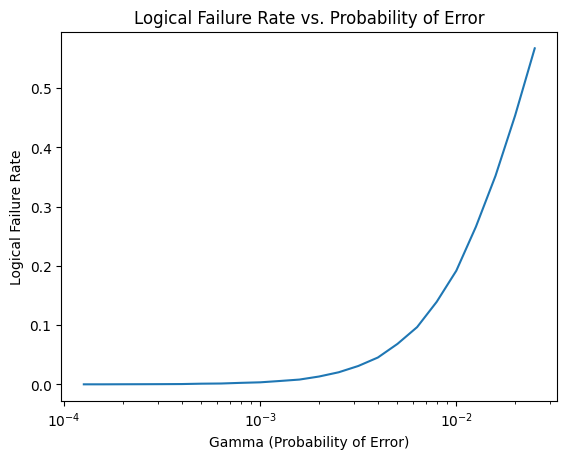

In [3]:
# Plot the graph
import matplotlib.pyplot as plt
gammas = [10**(i/10.-4) for i in range(21)]
import numpy as np
gammas = np.array([10**(i/10.-4) for i in range(low,high)])
plt.plot(gammas, logical_failure_rates)
plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.show()

In [4]:
print(logical_failure_rates)

[5e-05, 5e-05, 0.00016, 0.00024, 0.00035, 0.00051, 0.00113, 0.00143, 0.00252, 0.00343, 0.00568, 0.00808, 0.01323, 0.02038, 0.031, 0.0453, 0.06831, 0.09657, 0.13928, 0.19175, 0.26596, 0.35193, 0.45367, 0.56704]


In [5]:
#STEANE 713
# Implement the fault-tolerant error correction of [[7,1,3]] code using Steane's scheme. For the preparation of logical states, we adopt the simpler two-ancialla scheme in our paper.

from utility import *

# Prepare logical |0> and |+> states for syndrome measurement, following the circuit in Appendix C FIG. 9, which uses bare flag ancilla.
def prepLogical0(errors, errorRates, verbose):
  z = 1
  while(z):
    prepX(7, errors, errorRates)
    prepX(8, errors, errorRates)
    prepX(10, errors, errorRates)
    prepZ(9, errors, errorRates)
    prepZ(11, errors, errorRates)
    prepZ(12, errors, errorRates)
    prepZ(13, errors, errorRates)
    prepZ(14, errors, errorRates)
    cnot(7, 14, errors, errorRates)
    cnot(8,  14, errors, errorRates)
    cnot(10, 14, errors, errorRates)
    cnot(7, 9, errors, errorRates)
    cnot(7, 11, errors, errorRates)
    cnot(7, 13, errors, errorRates)
    cnot(8, 9, errors, errorRates)
    cnot(8, 12, errors, errorRates)
    cnot(8, 13, errors, errorRates)
    cnot(10, 11, errors, errorRates)
    cnot(10, 12, errors, errorRates)
    cnot(10, 13, errors, errorRates)
    cnot(10, 14, errors, errorRates)
    cnot(8, 14, errors, errorRates)
    cnot(7, 14, errors, errorRates)
    z = measZ(14, errors, errorRates)
    if verbose&z:
        print("ancilla zero fail")

def prepLogicalPlus(errors, errorRates, verbose):
  z = 1
  while(z):
    prepZ(7, errors, errorRates)
    prepZ(8, errors, errorRates)
    prepZ(10, errors, errorRates)
    prepX(9, errors, errorRates)
    prepX(11, errors, errorRates)
    prepX(12, errors, errorRates)
    prepX(13, errors, errorRates)
    prepX(14, errors, errorRates)
    cnot(14, 7, errors, errorRates)
    cnot(14, 8, errors, errorRates)
    cnot(14, 10, errors, errorRates)
    cnot(9, 7, errors, errorRates)
    cnot(11, 7, errors, errorRates)
    cnot(13, 7, errors, errorRates)
    cnot(9, 8, errors, errorRates)
    cnot(12, 8, errors, errorRates)
    cnot(13, 8, errors, errorRates)
    cnot(11, 10, errors, errorRates)
    cnot(12, 10, errors, errorRates)
    cnot(13, 10, errors, errorRates)
    cnot(14, 10, errors, errorRates)
    cnot(14, 8, errors, errorRates)
    cnot(14, 7, errors, errorRates)
    z = measX(14, errors, errorRates)
    if verbose&z:
        print("ancilla zero fail")

# Perform transversal cnot between data block and logical |0> and |+>. Correct the error through parity checks.
def correctErrors(errors, errorRates, verbose=False):
  if verbose: print("starting Xsyndrome")
  prepLogical0(errors, errorRates, verbose)
  Xsyndrome = 0
  for i in range(7):
    cnot(7+i, i, errors, errorRates)
    if measX(7+i, errors, errorRates):
      Xsyndrome ^= (1+i)
  if Xsyndrome:
    errors.z ^= 1<<(Xsyndrome-1)
  if verbose: print("starting Zsyndrome")
  prepLogicalPlus(errors, errorRates, verbose)
  Zsyndrome = 0
  for i in range(7):
    cnot(i, 7+i, errors, errorRates)
    if measZ(7+i, errors, errorRates):
      Zsyndrome ^= (1+i)
  if Zsyndrome:
    errors.x ^= 1<<(Zsyndrome-1)

# Find least weight representation modulo stabilizers.
def weight(errors):
  return bin((errors.x | errors.z) & ((1 << 7) - 1)).count("1")

def reduceError(errors): 
  stabilizers = \
  [[(1<<6)+(1<<5)+(1<<4)+(1<<3),0], \
  [(1<<6)+(1<<5)+(1<<2)+(1<<1),0], \
  [(1<<6)+(1<<4)+(1<<2)+(1<<0),0], \
  [0,(1<<6)+(1<<5)+(1<<4)+(1<<3)], \
  [0,(1<<6)+(1<<5)+(1<<2)+(1<<1)], \
  [0,(1<<6)+(1<<4)+(1<<2)+(1<<0)], \
  ]
  bestErrors = Errors(errors.x, errors.z)
  bestWeight = weight(bestErrors)
  trialErrors = Errors(0, 0)
  for k in range(1, 1<<(len(stabilizers))):
    trialErrors.x = errors.x
    trialErrors.z = errors.z
    for digit in range(len(stabilizers)):
      if (k>>digit)&1: 
        trialErrors.x ^= stabilizers[digit][0]
        trialErrors.z ^= stabilizers[digit][1]
    if weight(trialErrors) < bestWeight: 
      bestErrors.x = trialErrors.x
      bestErrors.z = trialErrors.z
      bestWeight = weight(bestErrors)
  return bestErrors

# Run consecutive trials of error correction with physical error rate of gamma, and count the number of failures, i.e., when the trialing error is not correctable by perfect error correction.
# The logical error rate is calculated as the ratio of failures over trials. 
def simulateErrorCorrection(gamma, trials): 
  errors = Errors(0, 0)
  errorsCopy = Errors(0, 0)
  
  errorRates0 = ErrorRates(0, 0, 0)
  errorRates = ErrorRates((4/15.)*gamma, gamma, (4/15.)*gamma)
  print(errorRates)
  failures = 0
  for k in range(trials): 
    correctErrors(errors, errorRates)
    errorsCopy.x = errors.x
    errorsCopy.z = errors.z
    correctErrors(errorsCopy, errorRates0)
    errorsCopy = reduceError(errorsCopy)
    if (errorsCopy.x & ((1<<7)-1)) or (errorsCopy.z & ((1<<7)-1)): 
      failures += 1
      errors.x = 0
      errors.z = 0
  print (failures)
  return failures/trials

In [6]:
# Wrapper function for the plot. More trials are needed for small gammas due to the confidence interval.
# gammas = [10**(i/10.-4) for i in range(21)]
# logical_failure_rates = []
# for i in range(10):
#   print "gamma=10^(%d/10-4), trials=10^7"% i
#   simulateErrorCorrection(gammas[i], 10**7)
# for i in range(11):
#   gamma = 10**(i/10.-4)
#   print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
#   simulateErrorCorrection(gammas[i+10], 10**6)
logical_failure_rates = []
for i in range(low,high):
    gamma = 10**(i/10.-4)
    print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
    logical_failure_rate = simulateErrorCorrection(gamma,trialsforall)
    logical_failure_rates.append(logical_failure_rate)
logical_failure_rates_steane713=logical_failure_rates

gamma=10^(11/10-4), trials=10^6
0
gamma=10^(12/10-4), trials=10^6
1
gamma=10^(13/10-4), trials=10^6
3
gamma=10^(14/10-4), trials=10^6
3
gamma=10^(15/10-4), trials=10^6
7
gamma=10^(16/10-4), trials=10^6
6
gamma=10^(17/10-4), trials=10^6
11
gamma=10^(18/10-4), trials=10^6
32
gamma=10^(19/10-4), trials=10^6
39
gamma=10^(20/10-4), trials=10^6
59
gamma=10^(21/10-4), trials=10^6
100
gamma=10^(22/10-4), trials=10^6
152
gamma=10^(23/10-4), trials=10^6
247
gamma=10^(24/10-4), trials=10^6
402
gamma=10^(25/10-4), trials=10^6
576
gamma=10^(26/10-4), trials=10^6
891
gamma=10^(27/10-4), trials=10^6
1361
gamma=10^(28/10-4), trials=10^6
2120
gamma=10^(29/10-4), trials=10^6
3156
gamma=10^(30/10-4), trials=10^6
4653
gamma=10^(31/10-4), trials=10^6
6947
gamma=10^(32/10-4), trials=10^6
9720
gamma=10^(33/10-4), trials=10^6
13561
gamma=10^(34/10-4), trials=10^6
18672


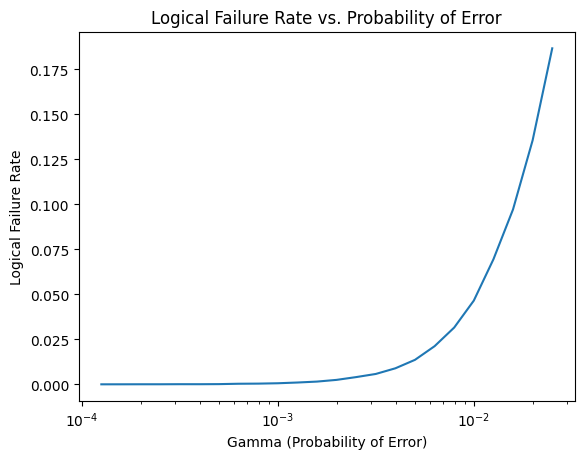

In [7]:
# Plot the graph
import numpy as np
import matplotlib.pyplot as plt
gammas = [10**(i/10.-4) for i in range(valuesxd)]
gammas = np.array([10**(i/10.-4) for i in range(low,high)])
plt.plot(gammas, logical_failure_rates)
plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.show()

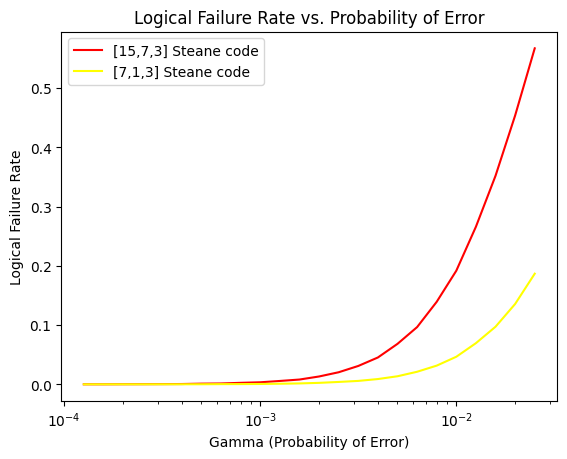

In [8]:
# # Plot the graph
# import matplotlib.pyplot as plt
# gammas = [10**(i/10.-4) for i in range(21)]
# plt.plot(gammas, logical_failure_rates_steane1573,color='red',label='[15,7,3] code',logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# plt.xlabel('Gamma (Probability of Error)')
# plt.ylabel('Logical Failure Rate')
# plt.xscale('log')
# plt.title('Logical Failure Rate vs. Probability of Error')
# plt.show()
# # plt.plot(gammas, logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# # plt.xlabel('Gamma (Probability of Error)')
# # plt.ylabel('Logical Failure Rate')
# # plt.xscale('log')
# # plt.title('Logical Failure Rate vs. Probability of Error')
# # plt.show()
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
gammas = np.array([10**(i/10.-4) for i in range(low,high)])
# Plot the logical failure rates for the [15,7,3] code in red

plt.plot(gammas, logical_failure_rates_steane1573, color='red', label='[15,7,3] Steane code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_steane713, color='yellow', label='[7,1,3] Steane code')
plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.legend()
plt.show()


In [9]:
#SHOR713
# Implement the fault-tolerant error correction of [[7,1,3]] code using Shor's scheme. 

from utility import *

# Perform weight-1 Pauli correction according to the syndromes of six stabilizers.
def correctErrorsUsingSyndromes(errors, syndromes): 
  xsyndrome = (syndromes[0]<<2) + (syndromes[1]<<1) + syndromes[2]
  if xsyndrome:
    errors.z ^= 1<<(xsyndrome-1)
  zsyndrome = (syndromes[3]<<2) + (syndromes[4]<<1) + syndromes[5]
  if zsyndrome:
    errors.x ^= 1<<(zsyndrome-1)

# Extract the syndromes of six stabilizers using one qubit a time.
def extractSyndromes(errors, errorRates): 
  syndromes = [0 for i in range(6)]
  prepX(7, errors, errorRates)
  cnot(7, 6, errors, errorRates)
  cnot(7, 5, errors, errorRates)
  cnot(7, 4, errors, errorRates)
  cnot(7, 3, errors, errorRates)
  syndromes[0] = measX(7, errors, errorRates)
  prepX(7, errors, errorRates)
  cnot(7, 6, errors, errorRates)
  cnot(7, 5, errors, errorRates)
  cnot(7, 2, errors, errorRates)
  cnot(7, 1, errors, errorRates)
  syndromes[1] = measX(7, errors, errorRates)
  prepX(7, errors, errorRates)
  cnot(7, 6, errors, errorRates)
  cnot(7, 4, errors, errorRates)
  cnot(7, 2, errors, errorRates)
  cnot(7, 0, errors, errorRates)
  syndromes[2] = measX(7, errors, errorRates)
  prepZ(7, errors, errorRates)
  cnot(6, 7, errors, errorRates)
  cnot(5, 7, errors, errorRates)
  cnot(4, 7, errors, errorRates)
  cnot(3, 7, errors, errorRates)
  syndromes[3] = measZ(7, errors, errorRates)
  prepZ(7, errors, errorRates)
  cnot(6, 7, errors, errorRates)
  cnot(5, 7, errors, errorRates)
  cnot(2, 7, errors, errorRates)
  cnot(1, 7, errors, errorRates)
  syndromes[4] = measZ(7, errors, errorRates)
  prepZ(7, errors, errorRates)
  cnot(6, 7, errors, errorRates)
  cnot(4, 7, errors, errorRates)
  cnot(2, 7, errors, errorRates)
  cnot(0, 7, errors, errorRates)
  syndromes[5] = measZ(7, errors, errorRates)
  return syndromes

# Prepare four-qubit cat state, following circuit in Section III A. Postselect on measuring trivial verification qubit. 
def prepCat(errors, errorRates, verbose):
  z = 1
  while(z):
    prepX(7, errors, errorRates)
    prepZ(8, errors, errorRates)
    prepZ(9, errors, errorRates)
    prepZ(10, errors, errorRates)
    cnot(7, 8, errors, errorRates)
    cnot(7, 9, errors, errorRates)
    cnot(7, 10, errors, errorRates)
    prepZ(11, errors, errorRates)
    cnot(7, 11, errors, errorRates)
    cnot(8, 11, errors, errorRates)
    z = measZ(11, errors, errorRates)
    if z&verbose: print("cat fail")

# Measure six stabilizers in turn, using cat states. Whenever have non-trivial syndrome, measure all stabilizers again with bare ancilla, because there is no fault anymore.
def correctErrors(errors, errorRates, verbose=False):
  if verbose: print("starting syndrome0")
  prepCat(errors, errorRates, verbose)
  cnot(7, 3, errors, errorRates)
  cnot(8, 4, errors, errorRates)
  cnot(9, 5, errors, errorRates)
  cnot(10, 6, errors, errorRates)
  if (measX(7, errors, errorRates)^measX(8, errors, errorRates)^measX(9, errors, errorRates)^measX(10, errors, errorRates))==1:
    if verbose: print("syndrome0")
    syndromes = extractSyndromes(errors, errorRates)
    if verbose: print(syndromes)
    correctErrorsUsingSyndromes(errors, syndromes)
    return 1
  if verbose: print("starting syndrome1")
  prepCat(errors, errorRates, verbose)
  cnot(7, 1, errors, errorRates)
  cnot(8, 2, errors, errorRates)
  cnot(9, 5, errors, errorRates)
  cnot(10, 6, errors, errorRates)
  if (measX(7, errors, errorRates)^measX(8, errors, errorRates)^measX(9, errors, errorRates)^measX(10, errors, errorRates))==1:
    if verbose: print("syndrome1")
    syndromes = extractSyndromes(errors, errorRates)
    if verbose: print(syndromes)
    correctErrorsUsingSyndromes(errors, syndromes)
    return 1
  if verbose: print("starting syndrome2")
  prepCat(errors, errorRates, verbose)
  cnot(7, 0, errors, errorRates)
  cnot(8, 2, errors, errorRates)
  cnot(9, 4, errors, errorRates)
  cnot(10, 6, errors, errorRates)
  if (measX(7, errors, errorRates)^measX(8, errors, errorRates)^measX(9, errors, errorRates)^measX(10, errors, errorRates))==1:
    if verbose: print("syndrome2")
    syndromes = extractSyndromes(errors, errorRates)
    if verbose: print(syndromes)
    correctErrorsUsingSyndromes(errors, syndromes)
    return 1
  if verbose: print("starting syndrome3")
  prepCat(errors, errorRates, verbose)
  cz(7, 3, errors, errorRates)
  cz(8, 4, errors, errorRates)
  cz(9, 5, errors, errorRates)
  cz(10, 6, errors, errorRates)
  if (measX(7, errors, errorRates)^measX(8, errors, errorRates)^measX(9, errors, errorRates)^measX(10, errors, errorRates))==1:
    if verbose: print("syndrome3")
    syndromes = extractSyndromes(errors, errorRates)
    if verbose: print(syndromes)
    correctErrorsUsingSyndromes(errors, syndromes)
    return 1
  if verbose: print("starting syndrome4")
  prepCat(errors, errorRates, verbose)
  cz(7, 1, errors, errorRates)
  cz(8, 2, errors, errorRates)
  cz(9, 5, errors, errorRates)
  cz(10, 6, errors, errorRates)
  if (measX(7, errors, errorRates)^measX(8, errors, errorRates)^measX(9, errors, errorRates)^measX(10, errors, errorRates))==1:
    if verbose: print("syndrome4")
    syndromes = extractSyndromes(errors, errorRates)
    if verbose: print(syndromes)
    correctErrorsUsingSyndromes(errors, syndromes)
    return 1
  if verbose: print("starting syndrome5")
  prepCat(errors, errorRates, verbose)
  cz(7, 0, errors, errorRates)
  cz(8, 2, errors, errorRates)
  cz(9, 4, errors, errorRates)
  cz(10, 6, errors, errorRates)
  if (measX(7, errors, errorRates)^measX(8, errors, errorRates)^measX(9, errors, errorRates)^measX(10, errors, errorRates))==1:
    if verbose: print("syndrome5")
    syndromes = extractSyndromes(errors, errorRates)
    if verbose: print(syndromes)
    correctErrorsUsingSyndromes(errors, syndromes)
    return 1
  return 0

# Find least weight representation modulo stabilizers.
def weight(errors):
  return bin((errors.x | errors.z) & ((1 << 7) - 1)).count("1")

def reduceError(errors): 
  stabilizers = \
  [[(1<<6)+(1<<5)+(1<<4)+(1<<3),0], \
  [(1<<6)+(1<<5)+(1<<2)+(1<<1),0], \
  [(1<<6)+(1<<4)+(1<<2)+(1<<0),0], \
  [0,(1<<6)+(1<<5)+(1<<4)+(1<<3)], \
  [0,(1<<6)+(1<<5)+(1<<2)+(1<<1)], \
  [0,(1<<6)+(1<<4)+(1<<2)+(1<<0)], \
  ]
  bestErrors = Errors(errors.x, errors.z)
  bestWeight = weight(bestErrors)
  trialErrors = Errors(0, 0)
  for k in range(1, 1<<(len(stabilizers))):
    trialErrors.x = errors.x
    trialErrors.z = errors.z
    for digit in range(len(stabilizers)):
      if (k>>digit)&1: 
        trialErrors.x ^= stabilizers[digit][0]
        trialErrors.z ^= stabilizers[digit][1]
    if weight(trialErrors) < bestWeight: 
      bestErrors.x = trialErrors.x
      bestErrors.z = trialErrors.z
      bestWeight = weight(bestErrors)
  return bestErrors

# Run consecutive trials of error correction with physical error rate of gamma, and count the number of failures, i.e., when the trialing error is not correctable by perfect error correction.
# The logical error rate is calculated as the ratio of failures over trials. 
def simulateErrorCorrection(gamma, trials): 
  errors = Errors(0, 0)
  errorsCopy = Errors(0, 0)
  
  errorRates0 = ErrorRates(0, 0, 0)
  errorRates = ErrorRates((4/15.)*gamma, gamma, (4/15.)*gamma)
  
  failures = 0
  for k in range(trials): 
    correctErrors(errors, errorRates)
    errorsCopy.x = errors.x
    errorsCopy.z = errors.z
    correctErrors(errorsCopy, errorRates0)
    errorsCopy = reduceError(errorsCopy)
    if (errorsCopy.x & ((1<<7)-1)) or (errorsCopy.z & ((1<<7)-1)): 
      failures += 1
      errors.x = 0
      errors.z = 0
  print(failures)
  return failures/trials



In [10]:
# Wrapper function for the plot. More trials are needed for small gammas due to the confidence interval.
# gammas = [10**(i/10.-4) for i in range(21)]
# logical_failure_rates = []
# for i in range(10):
#   print "gamma=10^(%d/10-4), trials=10^7"% i
#   simulateErrorCorrection(gammas[i], 10**7)
# for i in range(11):
#   gamma = 10**(i/10.-4)
#   print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
#   simulateErrorCorrection(gammas[i+10], 10**6)
logical_failure_rates = []
for i in range(low,high):
    gamma = 10**(i/10.-4)
    print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
    logical_failure_rate = simulateErrorCorrection(gamma,trialsforall)
    logical_failure_rates.append(logical_failure_rate)
logical_failure_rates_shor713=logical_failure_rates

gamma=10^(11/10-4), trials=10^6
1
gamma=10^(12/10-4), trials=10^6
4
gamma=10^(13/10-4), trials=10^6
1
gamma=10^(14/10-4), trials=10^6
7
gamma=10^(15/10-4), trials=10^6
7
gamma=10^(16/10-4), trials=10^6
6
gamma=10^(17/10-4), trials=10^6
9
gamma=10^(18/10-4), trials=10^6
20
gamma=10^(19/10-4), trials=10^6
43
gamma=10^(20/10-4), trials=10^6
59
gamma=10^(21/10-4), trials=10^6
119
gamma=10^(22/10-4), trials=10^6
176
gamma=10^(23/10-4), trials=10^6
244
gamma=10^(24/10-4), trials=10^6
399
gamma=10^(25/10-4), trials=10^6
620
gamma=10^(26/10-4), trials=10^6
988
gamma=10^(27/10-4), trials=10^6
1489
gamma=10^(28/10-4), trials=10^6
2248
gamma=10^(29/10-4), trials=10^6
3433
gamma=10^(30/10-4), trials=10^6
5066
gamma=10^(31/10-4), trials=10^6
7631
gamma=10^(32/10-4), trials=10^6
10875
gamma=10^(33/10-4), trials=10^6
15342
gamma=10^(34/10-4), trials=10^6
20944


In [11]:
#SHOR1573
# Implement the fault-tolerant error correction of [[15,7,3]] code using Shor's scheme. 

from utility import *

# Perform weight-1 Pauli correction according to the syndromes of eight stabilizers.
def correctErrorsUsingSyndromes(errors, syndromes):
  xsyndrome = (syndromes[0]<<3) + (syndromes[1]<<2) + (syndromes[2]<<1) + syndromes[3]
  if xsyndrome:
    errors.z ^= 1<<(xsyndrome-1)
  zsyndrome = (syndromes[4]<<3) + (syndromes[5]<<2) + (syndromes[6]<<1) + syndromes[7]
  if zsyndrome:
    errors.x ^= 1<<(zsyndrome-1)

# This is the matrix indexing the non-identity positions of the stabilizers 
cnotWires = [[k for k in range(15) if ((k+1)>>(3-i))&1==1] for i in range(4)]

# Extract the syndromes of eight stabilizers using one qubit a time.
def extractXSyndromes(errors, errorRates):
  syndromes = [0 for i in range(8)]
  for i in range(4):
    prepX(15, errors, errorRates)
    for j in range(8):
      cnot(15, cnotWires[i][j], errors, errorRates)
    syndromes[i] = measX(15, errors, errorRates)
  return syndromes

def extractZSyndromes(errors, errorRates):
  syndromes = [0 for i in range(8)] 
  for i in range(4):
    prepZ(15, errors, errorRates)
    for j in range(8):
      cnot(cnotWires[i][j], 15, errors, errorRates)
    syndromes[i+4] = measZ(15, errors, errorRates)
  return syndromes

def extractSyndromes(errors, errorRates):
  xsyn = extractXSyndromes(errors, errorRates)
  zsyn = extractZSyndromes(errors, errorRates)
  return [xsyn[i]+zsyn[i] for i in range(8)]

# Prepare eight-qubit cat state, following circuit in Section III A. Postselect on measuring trivial verification qubit. 
def prepCat(errors, errorRates, verbose):
  z = 1
  while(z):
    prepX(15, errors, errorRates)
    prepZ(16, errors, errorRates)
    prepZ(17, errors, errorRates)
    prepZ(18, errors, errorRates)
    prepZ(19, errors, errorRates)
    prepZ(20, errors, errorRates)
    prepZ(21, errors, errorRates)
    prepZ(22, errors, errorRates)
    cnot(15, 16, errors, errorRates)
    cnot(15, 17, errors, errorRates)
    cnot(15, 18, errors, errorRates)
    cnot(15, 19, errors, errorRates)
    cnot(15, 20, errors, errorRates)
    cnot(15, 21, errors, errorRates)
    cnot(15, 22, errors, errorRates)
    prepZ(23, errors, errorRates)
    cnot(15, 23, errors, errorRates)
    cnot(16, 23, errors, errorRates)
    z = measZ(23, errors, errorRates)
    if verbose&z: print("cat fail")

# Measure eight stabilizers in turn, using cat states. Whenever have non-trivial syndrome, measure all stabilizers again with bare ancilla, because there is no fault anymore.
def correctErrors(errors, errorRates, verbose=False):
  for i in range(4):
    prepCat(errors, errorRates, verbose)
    for j in range(8):
      cnot(15+j, cnotWires[i][j], errors, errorRates)
    syndrome = 0
    for j in range(8):
      syndrome ^= measX(15+j, errors, errorRates)
    if syndrome:
      if verbose: print("syndrome%d"%i)
      syndromes = extractSyndromes(errors, errorRates)
      if verbose: print(syndromes)
      correctErrorsUsingSyndromes(errors, syndromes)
      return 1
  for i in range(4):
    prepCat(errors, errorRates, verbose)
    for j in range(8):
      cz(15+j, cnotWires[i][j], errors, errorRates)
    syndrome = 0
    for j in range(8):
      syndrome ^= measX(15+j, errors, errorRates)
    if syndrome:
      if verbose: print("syndrome%d"%(i+4))
      syndromes = extractSyndromes(errors, errorRates)
      if verbose: print(syndromes)
      correctErrorsUsingSyndromes(errors, syndromes)
      return 1
  return 0

# Find least weight representation modulo stabilizers.
def weight(errors):
  return bin((errors.x | errors.z) & ((1 << 15) - 1)).count("1")

stabilizers = [[0,0] for i in range(8)]
for i in range(4):
  for j in range(8):
    stabilizers[i][0] += 1<<cnotWires[i][j]
for i in range(4):
  for j in range(8):
    stabilizers[i+4][1] += 1<<cnotWires[i][j]

def reduceError(errors): 
  bestErrors = Errors(errors.x, errors.z)
  bestWeight = weight(bestErrors)
  trialErrors = Errors(0, 0)
  for k in range(1, 1<<(len(stabilizers))):
    trialErrors.x = errors.x
    trialErrors.z = errors.z
    for digit in range(len(stabilizers)):
      if (k>>digit)&1: 
        trialErrors.x ^= stabilizers[digit][0]
        trialErrors.z ^= stabilizers[digit][1]
    if weight(trialErrors) < bestWeight: 
      bestErrors.x = trialErrors.x
      bestErrors.z = trialErrors.z
      bestWeight = weight(bestErrors)
  return bestErrors

# Run consecutive trials of error correction with physical error rate of gamma, and count the number of failures, i.e., when the trialing error is not correctable by perfect error correction.
# The logical error rate is calculated as the ratio of failures over trials. 
def simulateErrorCorrection(gamma, trials): 
  errors = Errors(0, 0)
  errorsCopy = Errors(0, 0)
  
  errorRates0 = ErrorRates(0, 0, 0)
  errorRates = ErrorRates((4/15.)*gamma, gamma, (4/15.)*gamma)
  
  failures = 0
  for k in range(trials): 
    correctErrors(errors, errorRates)
    errorsCopy.x = errors.x
    errorsCopy.z = errors.z
    correctErrors(errorsCopy, errorRates0)
    errorsCopy = reduceError(errorsCopy)
    if (errorsCopy.x & ((1<<15)-1)) or (errorsCopy.z & ((1<<15)-1)): 
      failures += 1
      errors.x = 0
      errors.z = 0
  print(failures,failures/trials)
  return failures/trials


In [12]:
# Wrapper function for the plot. More trials are needed for small gammas due to the confidence interval.
# gammas = [10**(i/10.-4) for i in range(21)]
# for i in range(10):
#   print "gamma=10^(%d/10-4), trials=10^7"% i
#   simulateErrorCorrection(gammas[i], 10**7)
# for i in range(11):
#   print "gamma=10^(%d/10-4), trials=10^6"% (i+10)
#   simulateErrorCorrection(gammas[i+10], 10**6)
# Wrapper function for the plot. More trials are needed for small gammas due to the confidence interval.
# gammas = [10**(i/10.-4) for i in range(21)]
# logical_failure_rates = []
# for i in range(10):
#   print "gamma=10^(%d/10-4), trials=10^7"% i
#   simulateErrorCorrection(gammas[i], 10**7)
# for i in range(11):
#   gamma = 10**(i/10.-4)


#   print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
#   simulateErrorCorrection(gammas[i+10], 10**6)
logical_failure_rates = []
for i in range(low,high):
    gamma = 10**(i/10.-4)
    print("gamma=10^(%d/10-4), trials=10^6"% (i+10))
    logical_failure_rate = simulateErrorCorrection(gamma,trialsforall)
    logical_failure_rates.append(logical_failure_rate)
logical_failure_rates_shor1573=logical_failure_rates

gamma=10^(11/10-4), trials=10^6
7 7e-05
gamma=10^(12/10-4), trials=10^6
21 0.00021
gamma=10^(13/10-4), trials=10^6
29 0.00029
gamma=10^(14/10-4), trials=10^6
35 0.00035
gamma=10^(15/10-4), trials=10^6
74 0.00074
gamma=10^(16/10-4), trials=10^6
80 0.0008
gamma=10^(17/10-4), trials=10^6
146 0.00146
gamma=10^(18/10-4), trials=10^6
243 0.00243
gamma=10^(19/10-4), trials=10^6
376 0.00376
gamma=10^(20/10-4), trials=10^6
635 0.00635
gamma=10^(21/10-4), trials=10^6
886 0.00886
gamma=10^(22/10-4), trials=10^6
1377 0.01377
gamma=10^(23/10-4), trials=10^6
2199 0.02199
gamma=10^(24/10-4), trials=10^6
3254 0.03254
gamma=10^(25/10-4), trials=10^6
4871 0.04871
gamma=10^(26/10-4), trials=10^6
7292 0.07292
gamma=10^(27/10-4), trials=10^6
10492 0.10492
gamma=10^(28/10-4), trials=10^6
15078 0.15078
gamma=10^(29/10-4), trials=10^6
21280 0.2128
gamma=10^(30/10-4), trials=10^6
28618 0.28618
gamma=10^(31/10-4), trials=10^6
37916 0.37916
gamma=10^(32/10-4), trials=10^6
48076 0.48076
gamma=10^(33/10-4), trials

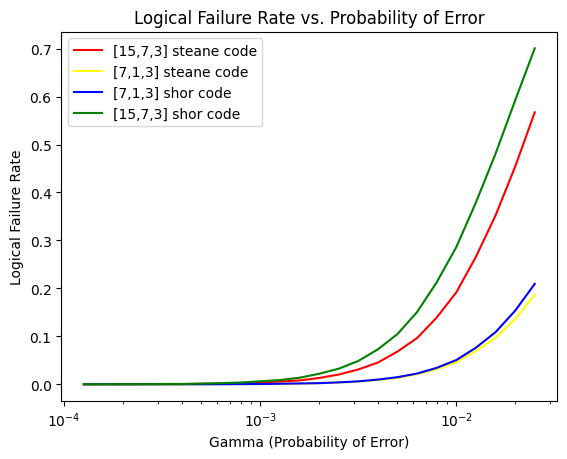

In [13]:
# # Plot the graph
# import matplotlib.pyplot as plt
# gammas = [10**(i/10.-4) for i in range(21)]
# plt.plot(gammas, logical_failure_rates_steane1573,color='red',label='[15,7,3] code',logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# plt.xlabel('Gamma (Probability of Error)')
# plt.ylabel('Logical Failure Rate')
# plt.xscale('log')
# plt.title('Logical Failure Rate vs. Probability of Error')
# plt.show()
# # plt.plot(gammas, logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# # plt.xlabel('Gamma (Probability of Error)')
# # plt.ylabel('Logical Failure Rate')
# # plt.xscale('log')
# # plt.title('Logical Failure Rate vs. Probability of Error')
# # plt.show()
import matplotlib.pyplot as plt

# Define the range of gamma values
gammas = [10**(i/10.-4) for i in range(21)]
import numpy as np
import matplotlib.pyplot as plt
gammas = np.array([10**(i/10.-4) for i in range(low,high)])
# Plot the logical failure rates for the [15,7,3] code in red
plt.plot(gammas, logical_failure_rates_steane1573, color='red', label='[15,7,3] steane code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_steane713, color='yellow', label='[7,1,3] steane code')

plt.plot(gammas, logical_failure_rates_shor713, color='blue', label='[7,1,3] shor code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_shor1573, color='green', label='[15,7,3] shor code')
plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.legend()
plt.show()


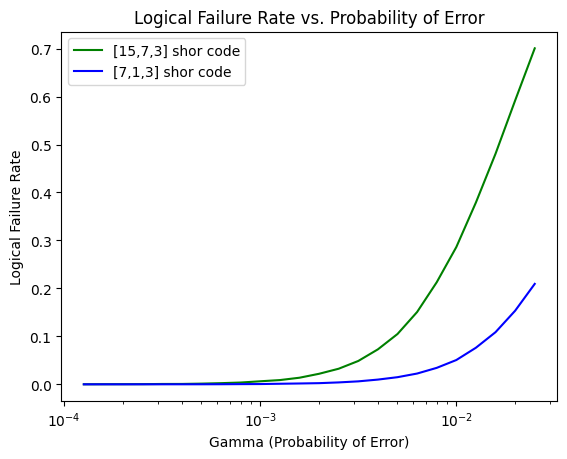

In [14]:
# # Plot the graph
# import matplotlib.pyplot as plt
# gammas = [10**(i/10.-4) for i in range(21)]
# plt.plot(gammas, logical_failure_rates_steane1573,color='red',label='[15,7,3] code',logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# plt.xlabel('Gamma (Probability of Error)')
# plt.ylabel('Logical Failure Rate')
# plt.xscale('log')
# plt.title('Logical Failure Rate vs. Probability of Error')
# plt.show()
# # plt.plot(gammas, logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# # plt.xlabel('Gamma (Probability of Error)')
# # plt.ylabel('Logical Failure Rate')
# # plt.xscale('log')
# # plt.title('Logical Failure Rate vs. Probability of Error')
# # plt.show()
import matplotlib.pyplot as plt

# Define the range of gamma values
gammas = [10**(i/10.-4) for i in range(low,high)]
import numpy as np
import matplotlib.pyplot as plt
gammas = np.array([10**(i/10.-4) for i in range(low,high)])
# Plot the logical failure rates for the [15,7,3] code in red
plt.plot(gammas, logical_failure_rates_shor1573, color='green', label='[15,7,3] shor code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_shor713, color='blue', label='[7,1,3] shor code')
plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.legend()
plt.show()


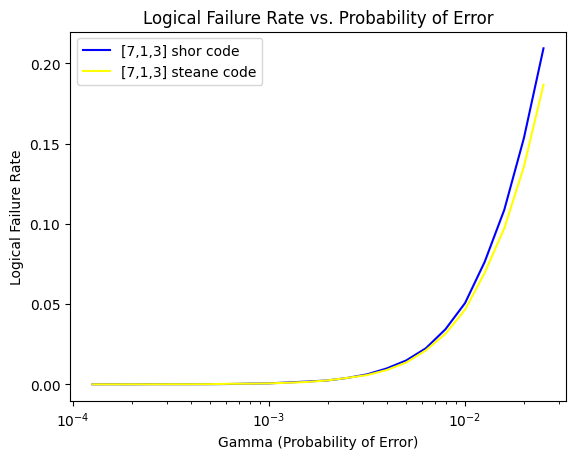

In [15]:
# # Plot the graph
# import matplotlib.pyplot as plt
# gammas = [10**(i/10.-4) for i in range(21)]
# plt.plot(gammas, logical_failure_rates_steane1573,color='red',label='[15,7,3] code',logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# plt.xlabel('Gamma (Probability of Error)')
# plt.ylabel('Logical Failure Rate')
# plt.xscale('log')
# plt.title('Logical Failure Rate vs. Probability of Error')
# plt.show()
# # plt.plot(gammas, logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# # plt.xlabel('Gamma (Probability of Error)')
# # plt.ylabel('Logical Failure Rate')
# # plt.xscale('log')
# # plt.title('Logical Failure Rate vs. Probability of Error')
# # plt.show()
import matplotlib.pyplot as plt

# Define the range of gamma values
gammas = [10**(i/10.-4) for i in range(low,high)]
import numpy as np
import matplotlib.pyplot as plt
gammas = np.array([10**(i/10.-4) for i in range(low,high)])

plt.plot(gammas, logical_failure_rates_shor713, color='blue', label='[7,1,3] shor code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_steane713, color='yellow', label='[7,1,3] steane code')

plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.legend()
plt.show()


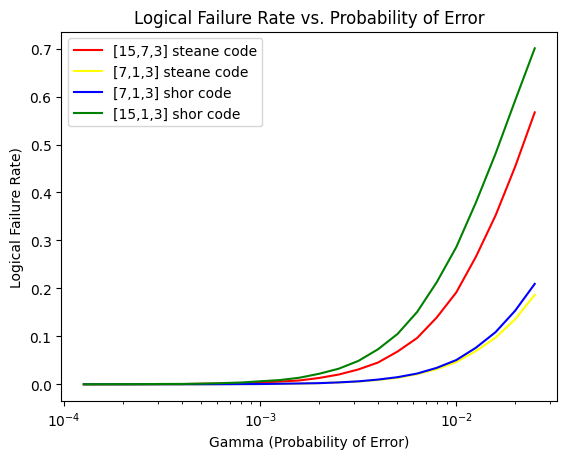

In [16]:
# # Plot the graph
# import matplotlib.pyplot as plt
# gammas = [10**(i/10.-4) for i in range(21)]
# plt.plot(gammas, logical_failure_rates_steane1573,color='red',label='[15,7,3] code',logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# plt.xlabel('Gamma (Probability of Error)')
# plt.ylabel('Logical Failure Rate')
# plt.xscale('log')
# plt.title('Logical Failure Rate vs. Probability of Error')
# plt.show()
# # plt.plot(gammas, logical_failure_rates_steane713,color='yellow',label='[7,1,3] code')
# # plt.xlabel('Gamma (Probability of Error)')
# # plt.ylabel('Logical Failure Rate')
# # plt.xscale('log')
# # plt.title('Logical Failure Rate vs. Probability of Error')
# # plt.show()
import matplotlib.pyplot as plt

# Define the range of gamma values
gammas = [10**(i/10.-4) for i in range(21)]
import numpy as np
import matplotlib.pyplot as plt
gammas = np.array([10**(i/10.-4) for i in range(low,high)])
# Plot the logical failure rates for the [15,7,3] code in red
plt.plot(gammas, logical_failure_rates_steane1573, color='red', label='[15,7,3] steane code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_steane713, color='yellow', label='[7,1,3] steane code')

plt.plot(gammas, logical_failure_rates_shor713, color='blue', label='[7,1,3] shor code')

# Plot the logical failure rates for the [7,1,3] code in yellow
plt.plot(gammas, logical_failure_rates_shor1573, color='green', label='[15,1,3] shor code')

plt.xlabel('Gamma (Probability of Error)')
plt.ylabel('Logical Failure Rate)')
plt.xscale('log')
plt.title('Logical Failure Rate vs. Probability of Error')
plt.legend()
plt.show()


In [ ]:
# Wrapper function for the plot. More trials are needed for small gammas due to the confidence interval.
gammas = [10**(i/10.-4) for i in range(21)]
for i in range(10):
  print "gamma=10^(%d/10-4), trials=10^7"% i
  simulateErrorCorrection(gammas[i], 10**7)
for i in range(11):
  print "gamma=10^(%d/10-4), trials=10^6"% (i+10)
  simulateErrorCorrection(gammas[i+10], 10**6)


##### 